# Chapter 5 - Applying Convnets to The Dogs vs Cats using Feature extraction without Data Augmentation

In [24]:
# Importing PlaidML. Make sure you follow this order
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [25]:
from keras.datasets import mnist
from keras import models, layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

import numpy as np
import shutil
import os

import matplotlib.pyplot as plt

In [15]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

## Instantiating the VGG16 convolutional base

In [17]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
conv_base.summary()

58892288/58889256 [==============================] - 12s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_poo

## Loading dataset

In [18]:
if 'DATASET_CATS_DOGS' in os.environ:
    original_dataset_dir = os.environ['DATASET_CATS_DOGS']
else:
    original_dataset_dir = "/Users/adriano.gil/workspace/datasets/dogs-vs-cats/train/"

if 'DATASET_CATS_DOGS_SMALL' in os.environ:
    base_dir = os.environ["DATASET_CATS_DOGS_SMALL"]
else:
    base_dir = "/Users/adriano.gil/workspace/datasets/dogs-vs-cats-small"
create_dir(base_dir)

In [19]:
train_dir = os.path.join(base_dir, 'train')
create_dir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
create_dir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
create_dir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
create_dir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
create_dir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
create_dir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
create_dir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
create_dir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
create_dir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [20]:
print('Total training cat images: ', len(os.listdir(train_cats_dir)))
print('Total training dog images: ', len(os.listdir(train_dogs_dir)))
print('Total validation cat images: ', len(os.listdir(validation_cats_dir)))
print('Total validation dog images: ', len(os.listdir(validation_dogs_dir)))
print('Total test cat images: ', len(os.listdir(test_cats_dir)))
print('Total test dogs images: ', len(os.listdir(test_dogs_dir)))

Total training cat images:  1000
Total training dog images:  1000
Total validation cat images:  500
Total validation dog images:  500
Total test cat images:  500
Total test dogs images:  500


## Preparing data

In [21]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))

ValueError: cannot reshape array of size 8192000 into shape (2000,8192)

In [32]:
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

## Generating Models

In [27]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizers.RMSprop(lr=2e-5),
        loss='binary_crossentropy',
        metrics=['acc']
    )
    return model

In [28]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


## Training model

In [33]:
history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)
model.save('catas_and_dogs_small_3.h5')

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6010 - acc: 0.6665 - val_loss: 0.4511 - val_acc: 0.8360
Epoch 2/30
2000/2000 [==============================] - 1s 526us/step - loss: 0.4353 - acc: 0.8025 - val_loss: 0.3707 - val_acc: 0.8650
Epoch 3/30
2000/2000 [==============================] - 1s 541us/step - loss: 0.3603 - acc: 0.8465 - val_loss: 0.3275 - val_acc: 0.8780
Epoch 4/30
2000/2000 [==============================] - 1s 550us/step - loss: 0.3217 - acc: 0.8700 - val_loss: 0.3038 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 1s 531us/step - loss: 0.2843 - acc: 0.8875 - val_loss: 0.2875 - val_acc: 0.8880
Epoch 6/30
2000/2000 [==============================] - 1s 528us/step - loss: 0.2672 - acc: 0.8930 - val_loss: 0.2781 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 1s 579us/step - loss: 0.2457 - acc: 0.9040 - val_loss: 0.2654 - val_acc: 0.9010
Ep

## Displaying curves of loss and accuracy during training

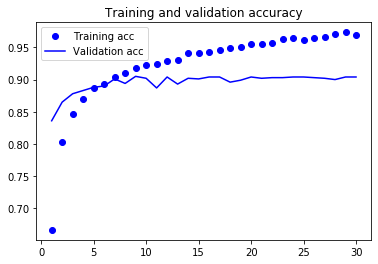

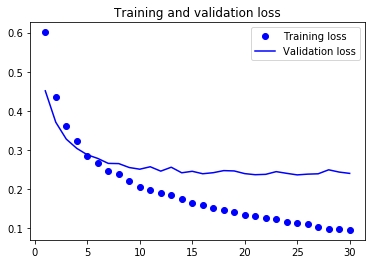

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
